# Interest Rates vs. Payments

Author: Arun Manohar

Email: arunmano121@outlook.com

License: BSD-3-Clause

Calculates the monthly payments given mortgage parameters, and graphically depict results for a variety of interest rates.

A variety of home prices and interest rates are considered and the resulting monthly commitment is plotted using a series a lines depicting the different home prices for various interest rates.

This program should aid the user to determine what kinds of home prices they could afford at different interest rates given their cap on monthly cash outflow and down payment.

In [8]:
# import necessary libraries

# plotting tools
import matplotlib.pyplot as plt
# numpy for array tasks
import numpy as np

In [9]:
# visualize results

def visualize_results(home_param):
    '''
    Plots the results including the range of interest rates on x-axis
    monthly commitment on the y-axis for the different home prices.
    the max budget line is also shown using dash-dot horizontal line.

    Parameters
    ----------
    home_param: dict
        parameters of the home and the calculated quantities

    Returns
    -------
    None
    '''

    fig, ax = plt.subplots(nrows=1, ncols=1)

    # descriptive title for the figure
    fig.suptitle(('Home value range: \\$%0.2fM - \\$%0.2fM, '
                  'Down payment: \\$%dK, '
                  '\nLoan Term: %d years, Monthly HOA/Mello-Roos: \\$%d, '
                  'Monthly Maint.: \\$%d')
                 % (home_param['home_val_lb']/1e6,
                    home_param['home_val_ub']/1e6,
                    home_param['down_pay']/1e3,
                    home_param['loan_term'], home_param['hoa'],
                    home_param['maint']))

    # plot line series
    # iterate through the different home values
    for i in range(len(home_param['home_val'])):
        ax.plot(np.squeeze(home_param['int_rate']),
                home_param['mon_commit'][i, :],
                label='%0.3f' % (home_param['home_val'][i]/1e6))

    # add horizontal line showing the max budget
    ax.axhline(home_param['mon_budget'],
               linestyle='-.', linewidth=2, label='Max. budget')

    ax.set_xlim([np.squeeze(home_param['int_rate'])[0],
                 np.squeeze(home_param['int_rate'])[-1]])
    ax.set_xlabel('Interest Rate [%]')
    ax.set_ylabel('Monthly Commitment ($)')
    ax.set_title('Monthly Commitment vs Interest Rate')
    # plot legend box outside of the main figure area
    ax.legend(title='Home price [\\$M]', bbox_to_anchor=(1.05, 1),
              loc='upper left', borderaxespad=0.)

    plt.grid()
    plt.tight_layout()
    plt.show()

    return


In [10]:
# calculate monthly payments

def calc_mon_pay(out_prin, months, int_rate, loan_type):
    '''
    calculate monthly payment including interest and principal

    Parameters
    ----------
    out_prin: float
        outstanding principal amount owed to bank
    months: int
        number of remaining months in loan
    int_rate: float
        fixed interest rate
    loan_type: str
        Indicator to specify if the loan is a regular loan or interest only

    Returns
    -------
    [payment, interest, principal]: list
        list containing total monthly payment to bank, interest component in
        the monthly payment, principal component in the monthly payment
    '''

    # monthly payment not including home ins and property tax and HOA
    # this only includes the loan amount based payment that is due to bank
    try:
        payment = (out_prin * (int_rate / (12 * 100)) /
                   (1 - (1 + int_rate / (12 * 100))**(-months)))
    except ZeroDivisionError:
        # if interest rate is 0%
        payment = out_prin/months

    # interest component
    interest = (int_rate/(12 * 100))*out_prin

    # principal component
    principal = payment - interest

    # interest only loan - so set back principal to 0
    if loan_type == 'I':
        principal = 0
        payment = interest

    return [payment, interest, principal]


In [11]:
# compute mortgage quantities

def compute_mortgage_quantities(home_param):
    '''
    based on user inputs for the parameters of the home, and other purchase
    factors such as HOA, property tax, etc., this function computes the
    calculated mortgage quantities

    Parameters
    ----------
    home_param: dict
        dictionary that contains the main input quantities and also carries
        the output and computed entities

    Returns
    -------
    home_param: dict
        dictionary that contains the main input quantities and also carries
        the output and computed entities
    '''

    # calculate the schedule of payments
    home_param['payment'], home_param['interest'], home_param['principal'] =\
        calc_mon_pay(home_param['loan_amt'], home_param['loan_term']*12,
                     home_param['int_rate'], home_param['loan_type'])

    # monthly property tax
    home_param['prop_tax'] = home_param['prop_tax_pct'] / (12*100) * \
        home_param['home_val']

    # monthly home insurance
    home_param['home_ins'] = home_param['prop_tax_pct'] / (12*100) * \
        home_param['home_val'] / 10

    # total monthly commitment is sum of payment to bank, hoa, home ins and
    # prop tax, maintenance
    home_param['mon_commit'] = home_param['payment'] + home_param['hoa'] + \
        home_param['home_ins'] + home_param['prop_tax'] + home_param['maint']

    return home_param

In [12]:
# ensure inputs are valid

def get_valid_input(msg):
    '''
    gets valid inputs for the home prices or down payments in a variety of
    formats - the user could enter like 1M or 1000000 or 1000K or $1M, etc.

    Parameters
    ----------
    msg: str
        message to be printed on the screen

    Returns
    -------
    None
    '''

    while True:
        try:
            # get input
            inp = input(msg)
            mod = float(inp.strip(' kK$%Mm,'))

            # check to see if value is in 1000's
            if 'k' in inp or 'K' in inp:
                val = mod * 1000

            # check to see if value is in 1000000's
            elif 'm' in inp or 'M' in inp:
                val = mod * 1000000

            # else value is as listed
            else:
                val = mod
            break

        except Exception as e:
            print(e)
            print('Enter as 100000 or $10,000 or $100K or 100K')

    return val


In [13]:
# obtain user inputs

def get_inputs(home_param):
    '''
    gets user inputs for the parameters of the home, and other purchase
    factors such as HOA, property tax, etc.

    Parameters
    ----------
    home_param: dict
        dictionary that contains the main input quantities and also carries
        the output and computed entities

    Returns
    -------
    home_param: dict
        dictionary that contains the main input quantities and also carries
        the output and computed entities
    '''

    # home value lower bound
    home_param['home_val_lb'] = get_valid_input('Home price lower range: ')

    # home value upper bound
    home_param['home_val_ub'] = get_valid_input('Home price upper range: ')

    # home price steps - like 25k, 50k, etc.
    home_param['steps'] = get_valid_input('Home price steps: ')

    # home value is in range between lower bound and upper bound
    # in steps of user specified value.
    home_param['home_val'] = \
        np.array(range(int(home_param['home_val_lb']),
                       int(home_param['home_val_ub']) + 1,
                       int(home_param['steps'])))
    # reshape to help with numpy broadcasting
    home_param['home_val'] = home_param['home_val'].reshape(
        len(home_param['home_val']), 1)

    # downpayment - typically less than 30% of home value or amount
    # enter maximum down payment possible
    home_param['down_pay'] = \
        get_valid_input('Enter max possible down payment: ')

    # regular loan or interest only loan
    home_param['loan_type'] = str(input('Reg. loan (R) or Int. only (I): '))

    # loan amount is home value minus down payment
    home_param['loan_amt'] = home_param['home_val'] - home_param['down_pay']

    # loan term
    home_param['loan_term'] = int(input('Loan term (years): '))

    # Monthly HOA and Mello-Roos
    home_param['hoa'] = int(input('Monthly HOA and Mello-Roos ($): '))

    # Monthly maintenance
    home_param['maint'] = int(input('Monthly maintenance ($): '))

    # max monthly cash available
    home_param['mon_budget'] = int(input('Monthly max budget ($): '))

    # monthly property tax - typically around 1.25% in San Diego, CA area
    home_param['prop_tax_pct'] = \
        float(input('Enter property tax percentage (%): '))

    # interest rate - simulate between desired interest rate range in
    # steps of 0.25%
    msg = 'Enter interest rate range seperated by (-): '
    int_rate = np.array(input(msg).strip('% ').split('-'))
    # adding delta of 0.01 to upper bound so that it is included
    int_rate = np.arange(float(int_rate[0]), float(int_rate[-1])+0.01, 0.25)
    # reshape to help with numpy broadcasting
    home_param['int_rate'] = int_rate.reshape(1, len(int_rate))

    return home_param


Home price lower range:  1.2m
Home price upper range:  2m
Home price steps:  100k
Enter max possible down payment:  500K
Reg. loan (R) or Int. only (I):  R
Loan term (years):  30
Monthly HOA and Mello-Roos ($):  0
Monthly maintenance ($):  500
Monthly max budget ($):  8000
Enter property tax percentage (%):  1.125
Enter interest rate range seperated by (-):  3-9


/var/folders/hh/dqj_ljzs6ms3qdk1tjq7gqzw0000gn/T/ipykernel_9276/1632638934.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label='%0.3f' % (home_param['home_val'][i]/1e6))


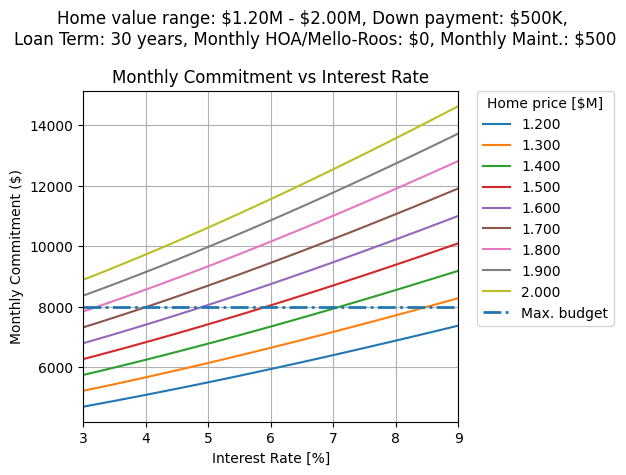

In [14]:
# main section that calls the other functions

# dictionary to store the essential parameters
home_param = {}

# get inputs
home_param = get_inputs(home_param)

# computing mortgage quantities
home_param = compute_mortgage_quantities(home_param)

# visualize the results
visualize_results(home_param)
